## Working With Data From The CROCUS Doppler LIDAR Deployed During AGES+

The CROCUS Scanning Doppler LIDAR was deployed to the NEIU Level Three rooftop node for July and August for NASA/NOAA AGES+. We have been running a crude ingest for the verticaly pointing data. This notebook gives an example of how to use and access this data.

For enquires contact 
Scott Collis scollis@anl.gov
Paytsar Muradyan pmuradyan@anl.gov
Max Grover mgrover@anl.gov

![alternatvie text](DL.png)

In [1]:
import numpy as np
from netCDF4 import Dataset
import os
import datetime
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pyart #This will be replaced by cmweather in the future
import act
import glob

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/Users/scollis/miniconda3/envs/crocus/lib/python3.11/site-packages/pyart/io/nexrad_level3.py:72: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from xdrlib import Unpacker


Open the dataset - This will be replaced with a THREDDS call

In [2]:
ds_ingested = act.io.read_arm_netcdf('/Volumes/T7/data/DL_ingested/crocus-neiu-dlvpt-a1-202308020000.nc')

Lets see what we have!

In [3]:
ds_ingested

/Users/scollis/miniconda3/envs/crocus/lib/python3.11/site-packages/xarray/core/formatting_html.py:22: DeprecationWarning: read_binary is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  read_binary(package, resource).decode("utf-8")
/Users/scollis/miniconda3/envs/crocus/lib/python3.11/site-packages/xarray/core/formatting_html.py:22: DeprecationWarning: read_binary is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  read_binary(package, resource).decode("utf-8")


<xarray.Dataset>
Dimensions:          (range: 500, time: 144257)
Coordinates:
  * range            (range) float64 12.0 36.0 60.0 ... 1.196e+04 1.199e+04
  * time             (time) datetime64[ns] 2023-08-02T00:00:44 ... 2023-08-02...
Data variables:
    radial_velocity  (range, time) float64 dask.array<chunksize=(500, 144257), meta=np.ndarray>
    beta             (range, time) float64 dask.array<chunksize=(500, 144257), meta=np.ndarray>
    intensity        (range, time) float64 dask.array<chunksize=(500, 144257), meta=np.ndarray>
Attributes:
    conventions:          CF 1.10
    site_ID:              NEIU
    CAMS_tag:             CMS-SDL-001
    datastream:           neiu-dopplerlidar-vpt-a1
    datalevel:            a1
    latitude:             41.9804526
    longitude:            -87.7196038
    _file_dates:          ['20230802']
    _file_times:          ['000044']
    _datastream:          neiu-dopplerlidar-vpt-a1
    _arm_standards_flag:  1

In [4]:
ds_ingested.intensity

<xarray.DataArray 'intensity' (range: 500, time: 144257)>
dask.array<open_dataset-0c64766fbbc55c4b84caad558b84b479intensity, shape=(500, 144257), dtype=float64, chunksize=(500, 144257), chunktype=numpy.ndarray>
Coordinates:
  * range    (range) float64 12.0 36.0 60.0 ... 1.194e+04 1.196e+04 1.199e+04
  * time     (time) datetime64[ns] 2023-08-02T00:00:44 ... 2023-08-02T23:58:42

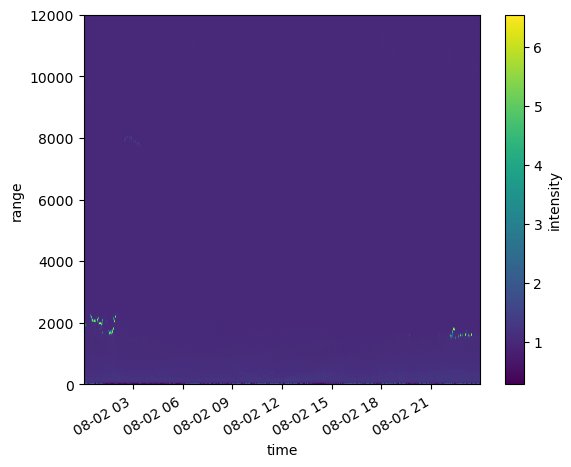

In [5]:
ds_ingested.intensity.plot()

Hmmm There is some data there but a a lot of data gathered around "6"

(0.0, 4000.0)

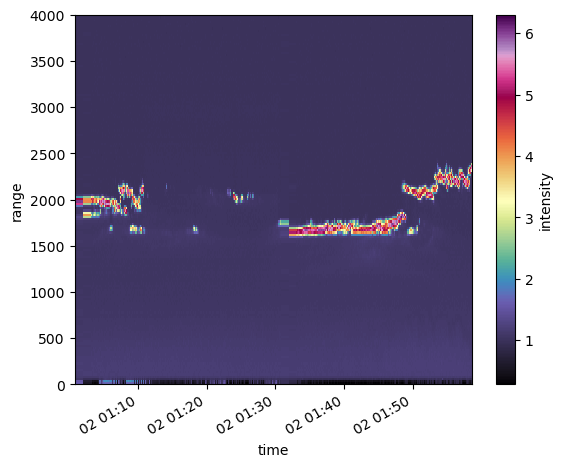

In [6]:
#time ranges
time1 = pd.Timestamp("2023-08-02 01:00:00")
time2 = pd.Timestamp("2023-08-02 02:00:00")

#Top of atmosphere
toa = 4000.0

#What ranges for Doppler Velocity
ds_ingested.intensity.sel(time=slice(time1,time2)).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.ChaseSpectral)


my_axis = plt.gca()
my_axis.set_ylim([0,toa])



Lets look at possible values... Lets do a histogram

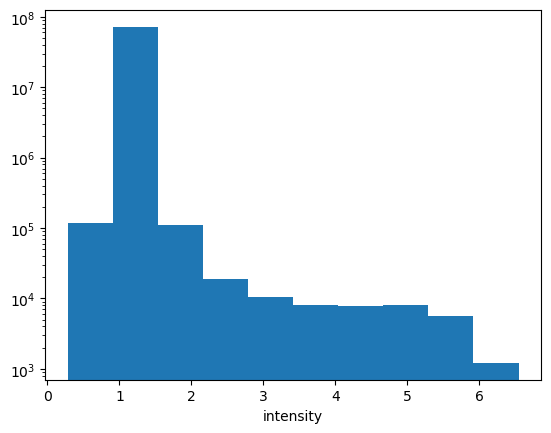

In [7]:
ds_ingested.intensity.plot.hist()
plt.yscale("log")

ok! So looking into the data for some reason the DL reports as Intensity + 1.. likely to avoid issues with negative logs.. so lets simply subtract one and scale the colormap to log

(0.0, 4000.0)

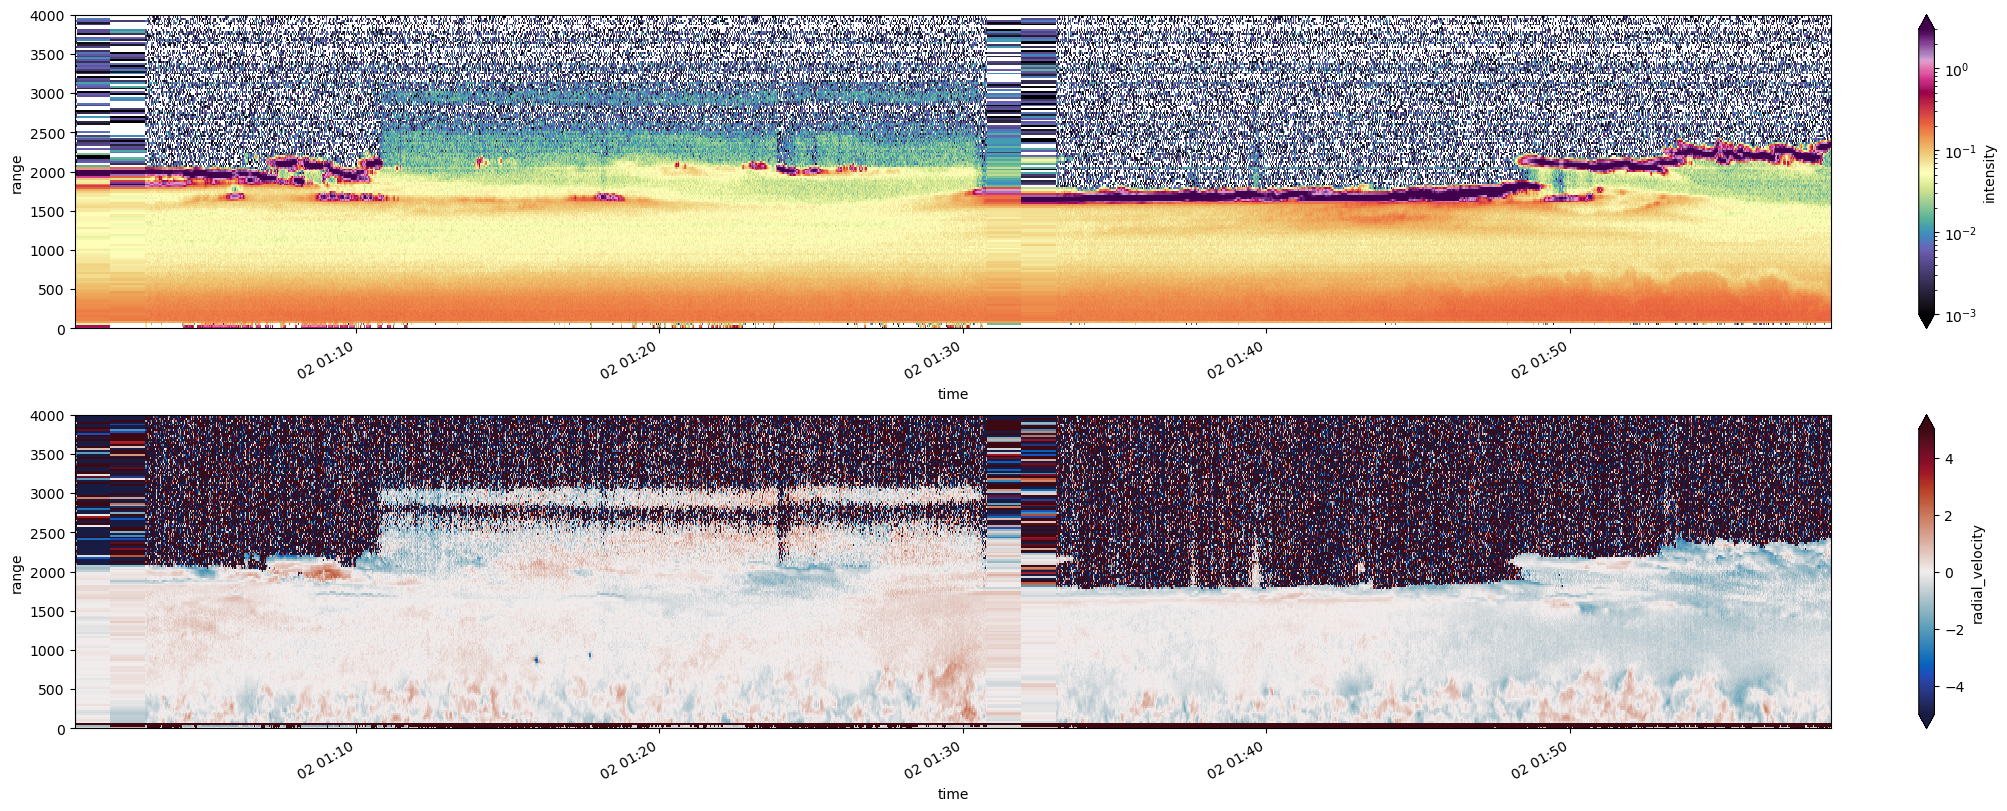

In [8]:

#time ranges
time1 = pd.Timestamp("2023-08-02 01:00:00")
time2 = pd.Timestamp("2023-08-02 02:00:00")

#Top of atmosphere
toa = 4000.0

#What ranges for Doppler Velocity
vrange = 5
fig, axs = plt.subplots( ncols=1, nrows=2, figsize=[20,8], constrained_layout=True)

#Units in the DL data are odd..
(ds_ingested.intensity -1.).sel(time=slice(time1,time2)).plot.pcolormesh(norm=LogNorm(vmax=3, vmin=0.001),
                                     cmap=pyart.graph.cm_colorblind.ChaseSpectral, ax=axs[0])


plt.ylabel("Height")
axs[0].set_ylim([0,toa])


ds_ingested.radial_velocity.sel(time=slice(time1,time2)).plot.pcolormesh( cmap=pyart.graph.cm_colorblind.balance, 
                                                                   vmin=-vrange, vmax=vrange, ax=axs[1])
axs[1].set_ylim([0,toa])




# Lovely..  now how about some insight

We know PBL heights are a key ask of the thematic groups. So lets play with looking at aggreating temporal data

This is inspired by the most excellent workshop run at the 2023 ARM-ASR PI meeting 
See: https://github.com/ARM-Development/ARM-Notebooks/blob/main/Tutorials/arm-asr-pi-meeting-2023/pandas_xarray_tutorial/Pandas_Xarray_intro.ipynb


Lets look at stats on an hour by hour window

In [9]:
window = 'time.hour'

#NB: For non standard intervals look at resample functions from the same ARM ASR Tutorial

new_ds = ds_ingested.groupby(window).mean()

(0.0, 4000.0)

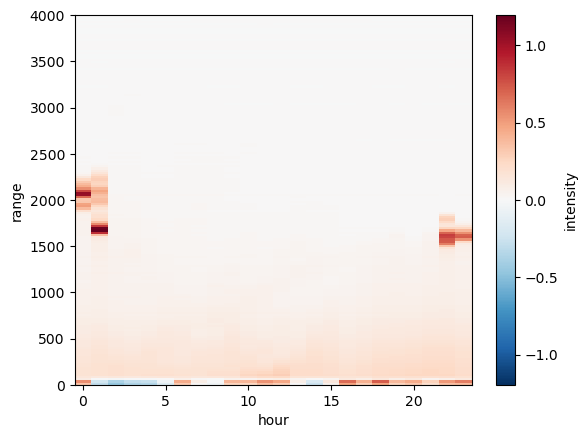

In [10]:
(new_ds.intensity-1.).transpose().plot()
my_axis = plt.gca()
my_axis.set_ylim([0,toa])



(0.0, 4000.0)

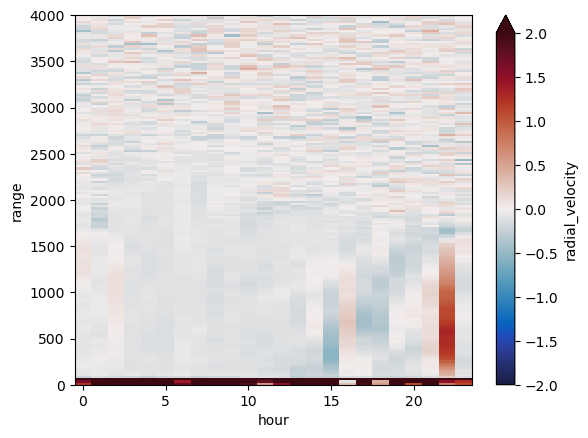

In [11]:
new_ds.radial_velocity.transpose().plot(vmin=-2, vmax=2,  cmap=pyart.graph.cm_colorblind.balance)
my_axis = plt.gca()
my_axis.set_ylim([0,toa])


## Cool! 
But now lets look at standard deviation over the hour...

(0.0, 4000.0)

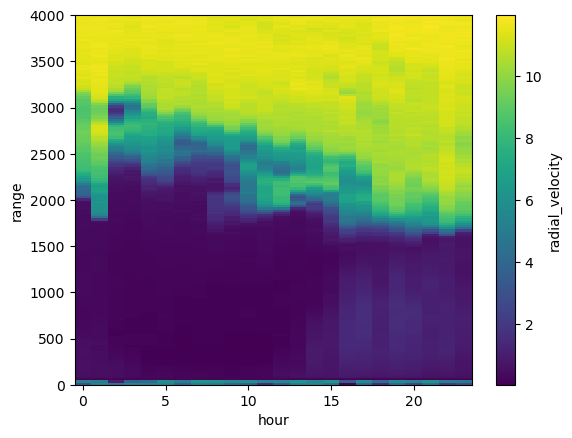

In [12]:
new_ds_stdev = ds_ingested.groupby(window).std()
new_ds_stdev.radial_velocity.transpose().plot()
my_axis = plt.gca()
my_axis.set_ylim([0,toa])



Ok.. there is something there but the signal is swamped by the "texture" from when we are below SNR thresholds. 

(0.0, 4000.0)

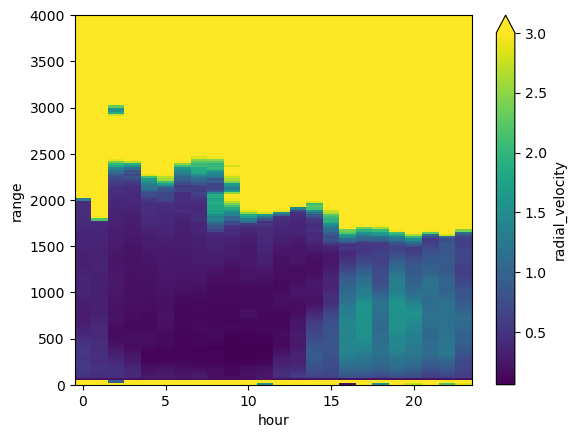

In [13]:
new_ds_stdev.radial_velocity.transpose().plot(vmax=3)
my_axis = plt.gca()
my_axis.set_ylim([0,toa])



### The idea: Conditionally sample based on intensity... 

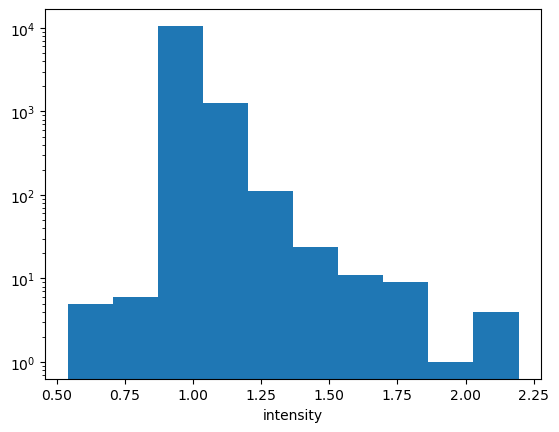

In [14]:
new_ds.intensity.plot.hist()
plt.yscale("log")




Woo Ho! Now lets make a data array which sets STDEV to zero when we think we are below detection limits..

In [15]:
filtered_da = new_ds_stdev.radial_velocity.where(new_ds.intensity > 1.01, 0)




(0.0, 4000.0)

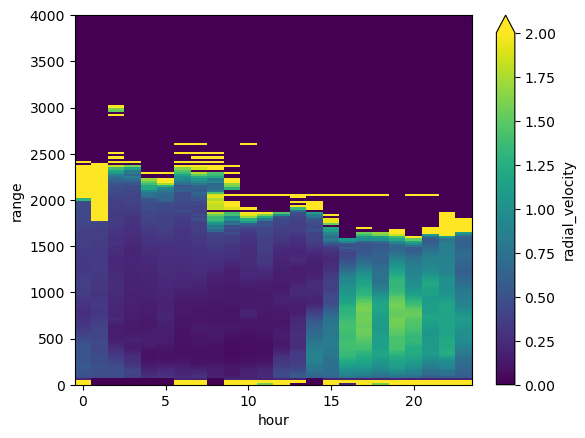

In [16]:
filtered_da.transpose().plot(vmax=2)
my_axis = plt.gca()
my_axis.set_ylim([0,toa])



In [ ]:
#This will take a LONG time to run

#Top of atmosphere
toa = 4000.0

#What ranges for Doppler Velocity
vrange = 5
fig, axs = plt.subplots( ncols=1, nrows=3, figsize=[20,12], constrained_layout=True)

#Units in the DL data are odd..
(ds_ingested.intensity -1.).plot.pcolormesh(norm=LogNorm(vmax=3, vmin=0.001),
                                     cmap=pyart.graph.cm_colorblind.ChaseSpectral, ax=axs[0])


plt.ylabel("Height")
axs[0].set_ylim([0,toa])


ds_ingested.radial_velocity.plot.pcolormesh( cmap=pyart.graph.cm_colorblind.balance, 
                                                                   vmin=-vrange, vmax=vrange, ax=axs[1])
axs[1].set_ylim([0,toa])


filtered_da.transpose().plot.pcolormesh(vmax=2, ax=axs[2])

axs[2].set_ylim([0,toa])




## Of course these profiles can now be a nice input to a ML model :) 